In [2]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.distributions as dist

import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
from pyro.distributions import Distribution

import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from Base.MetropolisHastings import MetropolisHastingsSampler
from elliptic_files.FEM_Solver import RootFinder,FEMSolver
from elliptic_files.utilities import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



np.random.seed(42)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tiaming Experiment 3

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

## Computing Roots

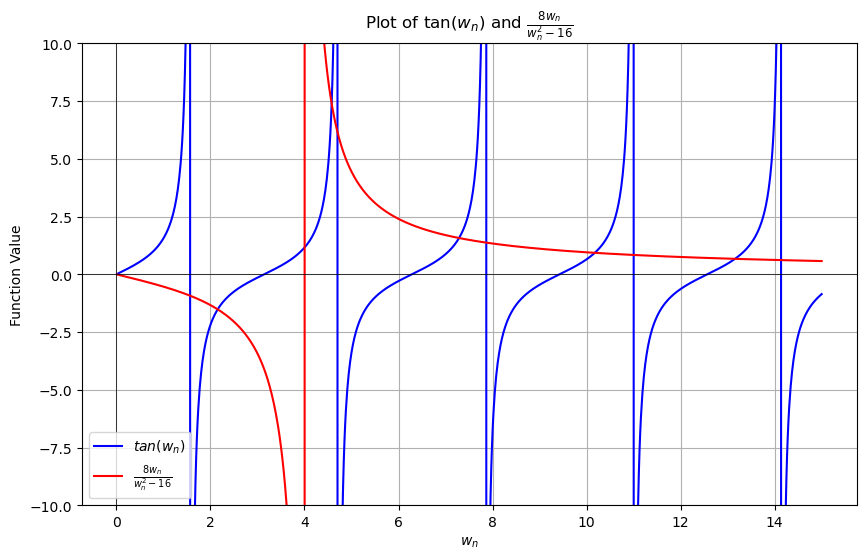

In [14]:

# Define the functions
def tan_func(wn):
    return np.tan(wn)

def rational_func(wn):
    return (8 * wn) / (wn**2 - 16)

# Create a range of values for wn avoiding the singularities of tan(wn)
wn_values = np.linspace(0, 15, 1000)

# To avoid the singularities at multiples of pi/2, let's exclude those values
wn_values = wn_values[(wn_values % (np.pi/2)) != 0]

# Evaluate the functions
tan_values = tan_func(wn_values)
rational_values = rational_func(wn_values)

# Plot the functions
plt.figure(figsize=(10, 6))
plt.plot(wn_values, tan_values, label=r'$tan(w_n)$', color='blue')
plt.plot(wn_values, rational_values, label=r'$\frac{8w_n}{w_n^2 - 16}$', color='red')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

# Add labels and title
plt.title(r'Plot of $\tan(w_n)$ and $\frac{8w_n}{w_n^2 - 16}$')
plt.xlabel(r'$w_n$')
plt.ylabel('Function Value')
plt.legend()
plt.ylim(-10, 10)  # Limit the y-axis to focus on intersections
plt.grid(True)
plt.show()


In [15]:
# Example Usage
lam = 1 / 4
M = 2

finder = RootFinder(lam, M)
roots = finder.find_roots()

print("Roots:", roots)

Roots: [2.15374797 4.57785946]


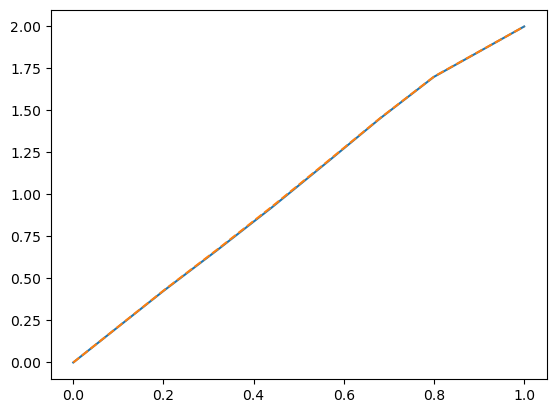

In [16]:
theta_th=np.array([0.098, 0.430])

dy = 6
x = [0] + list(np.linspace(0.2,0.8,dy)) + [1]

y_tia = [0,4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00,2]

solver = FEMSolver(theta_th, vert=10)
solver.solve()

y = solver.eval_at_points(np.array(x).reshape(-1, 1))


plt.plot(x,y_tia)
plt.plot(x,y,linestyle = "--")

# Moreau Yosida

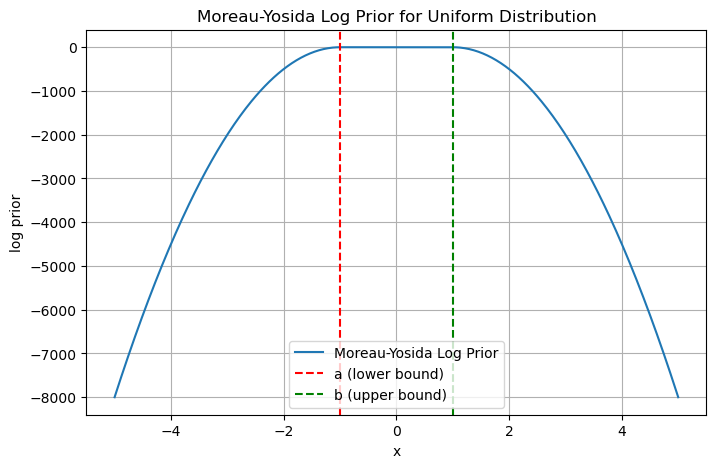

In [6]:

# Define the Moreau-Yosida log prior function
def log_prior_moreau_yosida(x, a, b, lam):
    log_prior = np.zeros_like(x)
    log_prior[x < a] = -(1 / (2 * lam)) * (x[x < a] - a)**2
    log_prior[x > b] = -(1 / (2 * lam)) * (x[x > b] - b)**2
    return log_prior

def log_uniform_moreau_yosida(x, lam):
    # Apply the Moreau-Yosida regularization term to the uniform distribution
    # Assuming x is the input parameter, and lam is the regularization parameter
    regularization_term =-(np.maximum(np.abs(x)-1, 0) ** 2) / (2 * lam)
    scaling_term = (2 + np.sqrt(2 * np.pi * lam)) ** (-1)
    
    return regularization_term +  np.log(scaling_term)

# Parameters for the uniform distribution
a = -1.0  # Lower bound
b = 1.0  # Upper bound
lam = 1e-3  # Regularization parameter (lambda)

# Generate a range of x values
x_vals = np.linspace(-5, 5, 500)

# Compute the log prior values
log_prior_vals = log_uniform_moreau_yosida(x_vals, lam)

# Plot the log prior
plt.figure(figsize=(8, 5))
plt.plot(x_vals, log_prior_vals, label='Moreau-Yosida Log Prior')
plt.axvline(a, color='r', linestyle='--', label='a (lower bound)')
plt.axvline(b, color='g', linestyle='--', label='b (upper bound)')
plt.xlabel('x')
plt.ylabel('log prior')
plt.title('Moreau-Yosida Log Prior for Uniform Distribution')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
class MoreauYosidaPrior(Distribution):
    def __init__(self, lam, batch_shape=torch.Size([]), device='cpu'):
        super().__init__()
        self.device = device
        self.batch_shape = torch.Size(batch_shape)  # Ensure batch_shape is a torch.Size object
        self.lam = torch.tensor(lam, dtype=torch.float32, device=self.device)


    @property
    def event_shape(self):
        """The event shape for this distribution is 1-dimensional."""
        return torch.Size([1])

    @property
    def support(self):
        """The support of the distribution is the whole real line."""
        return dist.constraints.real

    def log_prob(self, x):
        """Calculate the log probability of x under the Moreau-Yosida prior."""
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32, device=self.device)

        # Calculate the regularization term
        regularization_term = -(torch.clamp(torch.abs(x) - 1, min=0) ** 2) / (2 * self.lam)
        log_prob = regularization_term - torch.log(2 + torch.sqrt(2 * torch.pi * self.lam))

        return log_prob

    def sample(self, sample_shape=torch.Size()):
        """Sample from the Moreau-Yosida prior using importance sampling."""
        sample_shape = torch.Size(sample_shape)  # Ensure sample_shape is a torch.Size object
        total_shape = self.batch_shape + sample_shape  # Concatenate batch_shape with sample_shape

        # Proposal distribution with heavier tails (e.g., Normal distribution)
        proposal_dist = dist.Normal(loc=0.0, scale=2.0)  # Wider scale for more tail coverage
        proposals = proposal_dist.sample(total_shape).to(self.device)

        # Calculate log probabilities for the proposals under the Moreau-Yosida prior
        log_prob_samples = self.log_prob(proposals)

        # Calculate log probability of the proposal distribution
        log_prob_proposal = proposal_dist.log_prob(proposals)

        # Calculate weights for importance sampling
        weights = torch.exp(log_prob_samples - log_prob_proposal)

        # Clamp weights to avoid negative entries
        weights = torch.clamp(weights, min=0)

        # Normalize weights
        weights_sum = torch.sum(weights)
        if weights_sum > 0:  # Prevent division by zero
            weights /= weights_sum
        else:
            # If all weights are zero, return uniformly sampled values
            return proposals

        # Resample according to weights (multinomial resampling)
        idx = torch.multinomial(weights, total_shape[0], replacement=True)
        resampled_proposals = proposals[idx]

        return resampled_proposals

    def expand(self, batch_shape, _instance=None):
        """Expand the distribution to a new batch shape."""
        return MoreauYosidaPrior(self.lam, batch_shape, self.device)

# Example usage
lam = 0.001
my_prior = MoreauYosidaPrior(lam)

# Draw samples
num_samples = 10000
samples = my_prior.sample((num_samples,))
# Output some samples
print(f"Samples: {samples[:5]}")

Samples: tensor([ 0.8740,  0.8304,  0.5109,  0.5293, -0.5722])


(-3.0, 3.0)

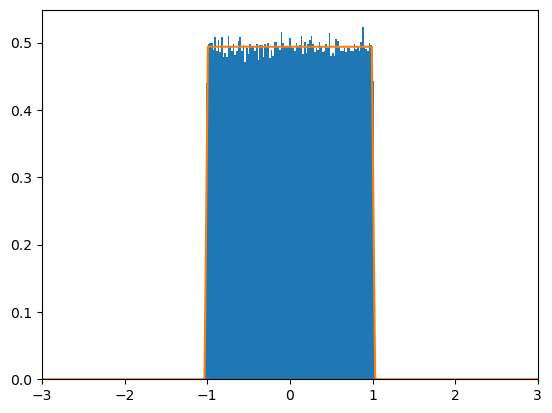

In [9]:

lam = 0.0001
my_prior = MoreauYosidaPrior(lam)

# Draw samples
num_samples = 1000000
samples = pyro.sample("theta", my_prior.expand([num_samples]))

def log_uniform_moreau_yosida(x, lam):
    # Apply the Moreau-Yosida regularization term to the uniform distribution
    # Assuming x is the input parameter, and lam is the regularization parameter
    regularization_term =-(np.maximum(np.abs(x)-1, 0) ** 2) / (2 * lam)
    scaling_term = (2 + np.sqrt(2 * np.pi * lam)) ** (-1)
    
    return regularization_term +  np.log(scaling_term)

# Generate a range of x values
x_vals = np.linspace(-5, 5, 500)

plt.hist(samples,density=True, bins=x_vals)
plt.plot(x_vals,np.exp(log_uniform_moreau_yosida(x_vals,lam)))
plt.xlim(-3,3)

# Samples from FEM using Moreau Yosida

In [20]:
theta_th=np.array([0.098, 0.430])
var = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]
obs = [10,25,50,100]
vertices = [50]

# for ob in obs:
#     for vr in var:
#         st = np.sqrt(vr)
#         obs_points, obs_sol = generate_noisy_obs(ob, theta_t=theta_th, mean=0, std=st,vert=200)

#         for hvert in vertices:

#             sampler = MetropolisHastingsSampler(obs_points, obs_sol, sig = st,numerical = True, roots=roots, vert=hvert)

#             samp_num,dt_tracker_num = sampler.run_sampler(n_chains=1005000)

#             np.save(f'./Models/FEM_h{hvert}_var{vr}_obs{ob}.npy', samp_num)

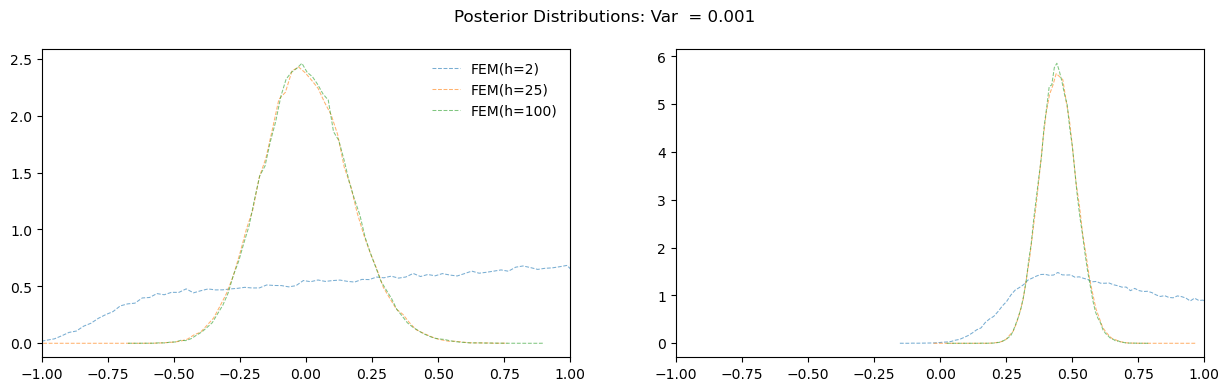

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4),sharex=True)
bins =80
var = [1e-3]
res = [2,25,100]

fig.suptitle(f"Posterior Distributions: Var  = {var[0]}")
for i,h in  enumerate(res):
    sample = np.load(f'./Models/FEM_h{h}_var{1e-3}_obs{10}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM(h={h})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM(h={h})")
    
axs[0].set_xlim(-1,1),axs[1].set_xlim(-1,1)
axs[0].legend(frameon = False)

In [11]:
grid  =25
parameter  = np.linspace(0,0.2,grid)

X, Y = np.meshgrid(parameter, parameter)
results = np.zeros((grid, grid, len(res)))

solver = FEMSolver(np.zeros(2), vert = 1000)

# Main loop over parameter space
for i, par1 in enumerate(parameter):
    for j, par2 in enumerate(parameter):
        pr = np.array([par1, par2])

        # Update the solver with new parameter values
        solver.theta = pr  # Update the parameter vector
        solver.uh = None  # Reset the FEM solution
        solver.solve()

        # Get FEM solution arrays
        x_FEM, y_FEM = solver.solution_array()
        x_FEM, y_FEM = x_FEM[:, 0].reshape(-1, 1), y_FEM.reshape(-1, 1)

        # Loop over observation sizes N
        for z, h in enumerate(res):
            solver2 = FEMSolver(np.zeros(2), vert = h)

            solver2.theta = pr  # Update the parameter vector
            solver2.uh = None  # Reset the FEM solution
            solver2.solve()

            y2 = solver2.eval_at_points(x_FEM).reshape(-1, 1)

            # Compute the maximum error between FEM and surrogate
            max_error = np.max(np.abs(y_FEM - y2))
            results[i, j, z] = max_error
            del solver2


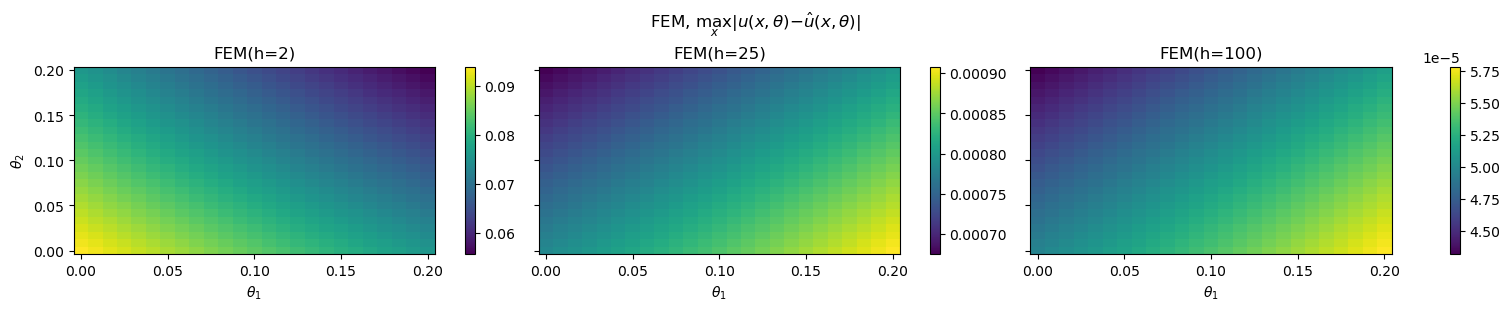

In [12]:
fig, axs = plt.subplots(1, len(res), figsize=(15, 3), layout="constrained", sharey=True)
fig.suptitle(fr"FEM, $\max_{{x}} | u(x, \theta) - \hat{{u}}(x, \theta)|$", fontsize=12)

for z, key in enumerate(res):
    Z = results[:, :, z]  # Extract the results for current N
    # Plot the heatmap for each N
    pcm = axs[z].pcolormesh(X, Y, Z, shading='auto')
    axs[z].set_xlabel(r"$\theta_1$")
    axs[z].set_title(f"FEM(h={key})")
    plt.colorbar(pcm, ax=axs[z])

axs[0].set_ylabel(r"$\theta_2$")  # Set common y-axis label
plt.show()

# Delayed Acceptance MH

In [2]:
class DAHM:
    """
    A class to perform Metropolis-Hastings sampling for parameter inference.
    It can use a neural network surrogate model or a numerical solver for likelihood evaluation.
    """

    def __init__(self, x, y, vert1=2, vert2 = 100, nparam=2, sig=1.0, dt_init=0.5, 
                  lam = 1 /4, M = 2, reg=1e-3, device='cpu'):
        """
        Initialize the Metropolis-Hastings sampler.
        
        Args:
            surrogate: Surrogate neural network model.
            x: Input data (independent variables).
            y: Observed data (dependent variables).
            sig: Standard deviation of the noise in the observations (default 1.0).
            dt_init: Initial step size for the proposal distribution (default 0.5).
            numerical: Whether to use a numerical solver instead of the surrogate model (default False).
            roots: Roots for FEM solver, used if numerical=True (optional).
            vert: Vertices for FEM solver, used if numerical=True (optional).
            lam: Regularization parameter for the Moreau-Yosida regularization.
            device: Device to run the model (default 'cpu').
        """
        self.device = device

        self.x = torch.tensor(x, dtype=torch.float32, device=self.device)
        self.y = torch.tensor(y, dtype=torch.float32, device=self.device)
        self.sig = torch.tensor(sig, dtype=torch.float32, device=self.device)
        self.dt = torch.tensor(dt_init, dtype=torch.float32, device=self.device)
        self.reg = torch.tensor(reg,dtype=torch.float32, device=self.device)  # Regularization parameter
        self.lam = lam
        self.M = M

        self.nparam = nparam
        self.vert1 = vert1
        self.vert2 = vert2


        # Initialize the FEMSolver once, if numerical solver is used
        self.solver1 = FEMSolver(np.zeros(self.nparam), self.lam,self.M, vert=self.vert1)
        self.solver2 = FEMSolver(np.zeros(self.nparam), self.lam,self.M, vert=self.vert2)


        self.scaling_term = 1 / (2 + torch.sqrt(2 * torch.pi * self.reg)).to(self.device)  # Calculate once


    def log_prior_alpha(self, theta):
        """
        Log prior with Moreau-Yosida regularization for the uniform distribution between -1 and 1.
        """
        # Regularization term for all theta values
        regularization_term = -(torch.clamp(torch.abs(theta) - 1, min=0) ** 2) / (2 * self.reg)
        return torch.sum(regularization_term + torch.log(self.scaling_term))

    def proposals(self, alpha):
        """
        Generates proposals for the next step in the Metropolis-Hastings algorithm using a normal distribution.
        Args:
            alpha: Current parameter values.
        
        Returns:
            New proposed parameter values.
        """
        # Generate normal proposals
        proposal = alpha + torch.normal(mean=torch.zeros_like(alpha), std=self.dt).to(self.device)
        
        return proposal

    def log_likelihood(self,solver,pr):

        """
        Evaluates the log-likelihood given the surrogate model or numerical solver.
        
        Args:
            pr: Current parameters.
        
        Returns:
            Log-likelihood value.
        """
        solver.theta = pr.cpu().numpy()  # Convert to numpy for FEM solver
        solver.solve()
        surg = solver.eval_at_points(self.x.cpu().numpy()).reshape(-1, 1)

        surg = torch.tensor(surg, device=self.device)

        return -0.5 * torch.sum(((self.y - surg) ** 2) / (self.sig ** 2))

        
    def log_posterior(self, solver,pr):
        """
        Evaluates the log-posterior using the surrogate model.
        
        Args:
            pr: Current parameters.
        
        Returns:
            Log-posterior value.
        """
        return self.log_likelihood(solver,pr) + self.log_prior_alpha(pr)

    def run_sampler(self, n_chains, verbose=True):
        """
        Run the Metropolis-Hastings sampling process sequentially.
        
        Args:
            n_chains: Number of steps in the chain.
            verbose: Whether to print progress (default True).
        
        Returns:
            alpha_samp: Sampled parameter values.
            dt_tracker: Step size progression over the chain.
        """
        # Initialize the parameters randomly within the prior range
        alpha = torch.empty(self.nparam, device=self.device).uniform_(-1, 1)
        alpha_samp = torch.zeros((n_chains, self.nparam), device=self.device)
        #dt_tracker = torch.zeros(n_chains, device=self.device)
        acceptance_rate = 0
        inner_mh = 0

        for i in range(n_chains):
            # Propose new alpha values
            alpha_proposal = self.proposals(alpha)
            
            # Compute the current log-posterior
            log_posterior_current = self.log_posterior(self.solver1,alpha)
            log_posterior_proposal = self.log_posterior(self.solver1,alpha_proposal)

            # Compute the acceptance ratio
            a = torch.clamp(torch.exp(log_posterior_proposal - log_posterior_current), max=1.0)

            # Accept or reject the proposal
            if torch.rand(1, device=self.device) < a:
                inner_mh += 1
                log_posterior_current2 = self.log_posterior(self.solver2,alpha)
                log_posterior_proposal2 = self.log_posterior(self.solver2,alpha_proposal)

                # Compute the acceptance ratio
                a = torch.clamp(torch.exp(log_posterior_proposal2 - (log_posterior_current2))*(1/a), max=1.0)

                if torch.rand(1, device=self.device) < a:
                    alpha = alpha_proposal
                    acceptance_rate += 1

            # Store the current sample and step size
            alpha_samp[i] = alpha
            #dt_tracker[i] = self.dt

            # Adaptive step size adjustment 
            #self.dt += self.dt * (a - 0.234) / (i + 1)

            del log_posterior_current, log_posterior_proposal, alpha_proposal
            if self.device != "cpu":
                torch.cuda.empty_cache()

            # Print progress every 10% of the steps
            if verbose and i % (n_chains // 10) == 0 and (i!=0):
                print(f"Iteration {i}, Acceptance Rate: {acceptance_rate / inner_mh:.3f}, Step Size: {self.dt:.4f}")
                #print(f"Iteration {i}, Acceptance Rate: {acceptance_rate / (i + 1):.3f}, Step Size: {self.dt:.4f}")

        # if verbose:
        #     print(f"Final Acceptance Rate: {acceptance_rate / n_chains:.3f}")
            
        return alpha_samp.detach().cpu().numpy()
        #return alpha_samp.detach().cpu().numpy(), dt_tracker.detach().cpu().numpy()


In [ ]:
theta_th=np.array([0.098, 0.430])

st = np.sqrt(1e-3)
obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)

dahm  = DAHM(obs_points, obs_sol,vert1=2, vert2 = 25, sig = st)
samples = dahm.run_sampler(1000000)

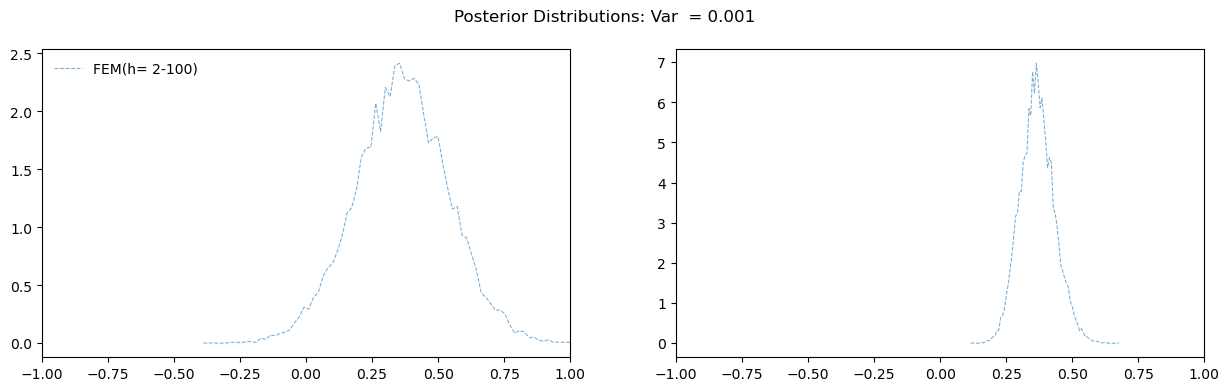

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4),sharex=True)
bins =80

samples = np.load("./results/DA_samples_c2f25.npy")

fig.suptitle(f"Posterior Distributions: Var  = {st**2:0.3}")
bin_centers, counts = histogram_(samples[:, 0],bins=bins)
axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM(h= 2-100)")
bin_centers, counts = histogram_(samples[:, 1],bins=bins)
axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM(h= 2-100)")

axs[0].set_xlim(-1,1),axs[1].set_xlim(-1,1)
axs[0].legend(frameon = False)

In [ ]:
dahm  = DAHM(obs_points, obs_sol,vert1=10, vert2 = 100, sig = st)
samples = dahm.run_sampler(100000)

Iteration 10000, Acceptance Rate: 0.915, Step Size: 0.5000
Iteration 20000, Acceptance Rate: 0.928, Step Size: 0.5000
Iteration 30000, Acceptance Rate: 0.922, Step Size: 0.5000
Iteration 40000, Acceptance Rate: 0.923, Step Size: 0.5000
Iteration 50000, Acceptance Rate: 0.922, Step Size: 0.5000
Iteration 60000, Acceptance Rate: 0.922, Step Size: 0.5000
Iteration 70000, Acceptance Rate: 0.923, Step Size: 0.5000
Iteration 80000, Acceptance Rate: 0.923, Step Size: 0.5000
Iteration 90000, Acceptance Rate: 0.923, Step Size: 0.5000
Final Acceptance Rate: 0.028


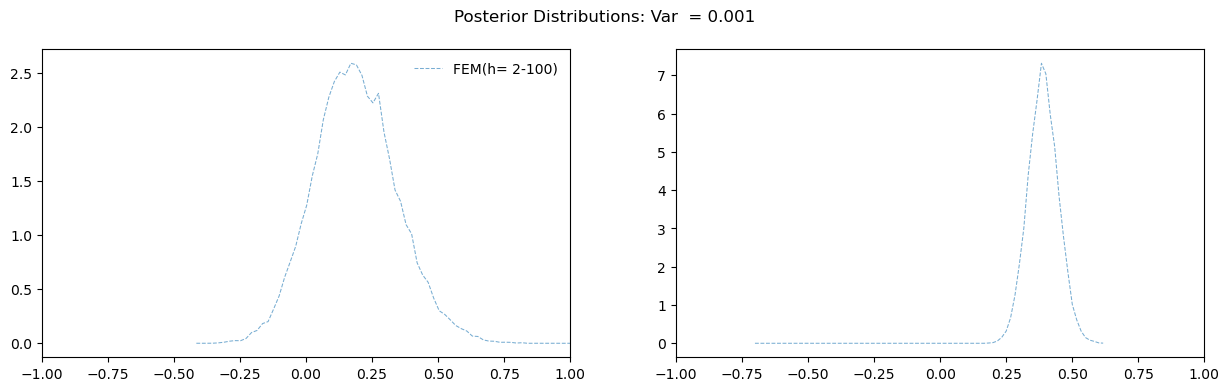

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4),sharex=True)
bins =80

samples = np.load("./results/DA_samples_c15f25.npy")


fig.suptitle(f"Posterior Distributions: Var  = {st**2:0.3}")
bin_centers, counts = histogram_(samples[:, 0],bins=bins)
axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM(h= 2-100)")
bin_centers, counts = histogram_(samples[:, 1],bins=bins)
axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM(h= 2-100)")

axs[0].set_xlim(-1,1),axs[1].set_xlim(-1,1)
axs[0].legend(frameon = False)

# Delayed acceptance with NN


In [17]:
class DAHM_NN:
    """
    A class to perform Metropolis-Hastings sampling for parameter inference.
    It can use a neural network surrogate model or a numerical solver for likelihood evaluation.
    """

    def __init__(self, x, y, nn_surrogate, vert = 100, nparam=2, sig=1.0, dt_init=0.5, 
                  lam = 1 /4, M = 2, reg=1e-3, device='cpu'):
        """
        Initialize the Metropolis-Hastings sampler.
        """
        self.device = device

        self.x = torch.tensor(x, dtype=torch.float32, device=self.device)
        self.y = torch.tensor(y, dtype=torch.float32, device=self.device)
        self.sig = torch.tensor(sig, dtype=torch.float32, device=self.device)
        self.dt = torch.tensor(dt_init, dtype=torch.float32, device=self.device)
        self.reg = torch.tensor(reg,dtype=torch.float32, device=self.device)  # Regularization parameter
        self.lam = lam
        self.M = M

        self.nparam = nparam
        self.vert = vert


        # Initialize the FEMSolver once, if numerical solver is used
        self.solver = FEMSolver(np.zeros(self.nparam), self.lam,self.M, vert=self.vert)
        self.surrogate = nn_surrogate

        self.scaling_term = 1 / (2 + torch.sqrt(2 * torch.pi * self.reg)).to(self.device)  # Calculate once


    def log_prior_alpha(self, theta):
        """
        Log prior with Moreau-Yosida regularization for the uniform distribution between -1 and 1.
        """
        # Regularization term for all theta values
        regularization_term = -(torch.clamp(torch.abs(theta) - 1, min=0) ** 2) / (2 * self.reg)
        return torch.sum(regularization_term + torch.log(self.scaling_term))

    def proposals(self, alpha):
        """
        Generates proposals for the next step in the Metropolis-Hastings algorithm using a normal distribution.
    
        """
        # Generate normal proposals
        proposal = alpha + torch.normal(mean=torch.zeros_like(alpha), std=self.dt).to(self.device)
        
        return proposal

    def log_likelihood(self,pr):

        """
        Evaluates the log-likelihood given the numerical solver.

        """
        self.solver.theta = pr.cpu().numpy()  # Convert to numpy for FEM solver
        self.solver.solve()
        surg = self.solver.eval_at_points(self.x.cpu().numpy()).reshape(-1, 1)

        surg = torch.tensor(surg, device=self.device)

        return -0.5 * torch.sum(((self.y - surg) ** 2) / (self.sig ** 2))
    
    def nn_log_likelihood(self,pr):

        """
        Evaluates the log-likelihood given the surrogate model.
        """
        data = torch.cat([self.x, pr.repeat(self.x.size(0), 1)], dim=1)
        surg = self.surrogate.model(data).detach().reshape(-1, 1)
        return -0.5 * torch.sum(((self.y - surg) ** 2) / (self.sig ** 2))

        
    def log_posterior(self,pr):
        """
        Evaluates the log-posterior using the numerical solver.
        """
        return self.log_likelihood(pr) + self.log_prior_alpha(pr)
    
    def nn_log_posterior(self,pr):
        """
        Evaluates the log-posterior using the numerical solver.
        """
        return self.nn_log_likelihood(pr) + self.log_prior_alpha(pr)
    

    def run_sampler(self,n_chains, alpha0 = None,burn_in=100000, verbose=True):
        """
        Run the Metropolis-Hastings sampling process sequentially.
        """
        # Initialize the parameters randomly within the prior range
        alpha = (torch.rand(self.nparam, device=self.device) * 2 - 1) if alpha0 == None else  alpha0
        alpha_samp_inner = torch.zeros((n_chains, self.nparam), device=self.device)
        alpha_samp_inner = torch.zeros((n_chains, self.nparam), device=self.device)

        outer_mh = 0 
        for i in range(burn_in):
            # Propose new alpha values
            alpha_proposal = self.proposals(alpha)
            
            # Compute the current log-posterior
            log_posterior_current = self.nn_log_posterior(alpha)
            log_posterior_proposal = self.nn_log_posterior(alpha_proposal)

            # Compute the acceptance ratio
            a = torch.clamp(torch.exp(log_posterior_proposal - log_posterior_current), max=1.0)

            if torch.rand(1, device=self.device) < a:
                alpha = alpha_proposal.clone()
                outer_mh += 1

            # Adaptive step size adjustment 
            self.dt += self.dt * (a - 0.234) / (i + 1)

            if verbose and i % (n_chains // 10) == 0 and (i!=0):
                print(f"Burn-in {i}, Acceptance Rate: {outer_mh / (i+1):.4f}, Step Size: {self.dt:.4f}")

        print("Starting Delayed Acceptance....")

        inner_accepted,inner_mh = 0,0
        for i in range(n_chains):
            # Propose new alpha values
            alpha_proposal = self.proposals(alpha)
            
            # Compute the current log-posterior
            log_posterior_current = self.nn_log_posterior(alpha)
            log_posterior_proposal = self.nn_log_posterior(alpha_proposal)

            # Compute the acceptance ratio
            a = torch.clamp(torch.exp(log_posterior_proposal - log_posterior_current), max=1.0)

            # Accept or reject the proposal
            if torch.rand(1, device=self.device) < a:
                inner_mh += 1
                log_posterior_current2 = self.log_posterior(alpha)
                log_posterior_proposal2 = self.log_posterior(alpha_proposal)

                # Compute the acceptance ratio
                a = torch.clamp(torch.exp(log_posterior_proposal2 - (log_posterior_current2))*(1/a), max=1.0)

                if torch.rand(1, device=self.device) < a:
                    alpha = alpha_proposal.clone()
                    inner_accepted += 1

            # Store the current sample and step size
            alpha_samp_inner[i] = alpha

            # Print progress every 10% of the steps
            if verbose and i % (n_chains // 10) == 0 and (i!=0):
                print(f"Iteration {i}, Acceptance Rate: {inner_accepted / inner_mh:.4f}, Step Size: {self.dt:.4f}")

        if verbose:
            print(f"Times inner step {inner_mh:.4f}, Acceptance Rate: {inner_accepted / inner_mh:.4f}")
            
        return alpha_samp_inner.detach().cpu().numpy()

In [20]:
dy = 6
st = np.sqrt(1e-5)

X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 5
dy = 6
eta = np.random.normal(0,10**(-k/2),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])
y = y_tia + eta

y = y.reshape(-1,1)

In [21]:
N = [150,250,500,750,1000,1500,2500]
for nobs in N:
    print(f"Starting NN: s_{nobs}")
    nn_surrogate_model = torch.load(f"./models/MDNN_s{nobs}.pth")
    nn_surrogate_model.eval()

    mcmc_nn = DAHM_NN(X,y,nn_surrogate_model,sig = st,dt_init=0.01)

    samples_ = mcmc_nn.run_sampler(n_chains=1000000,burn_in=500000)

    np.save(f'./results/delayed_neural_MCMCM_s{nobs}_var{1e-5}.npy', samples_)

Starting NN: s_150
Burn-in 100000, Acceptance Rate: 0.2320, Step Size: 0.0185
Burn-in 200000, Acceptance Rate: 0.2322, Step Size: 0.0185
Burn-in 300000, Acceptance Rate: 0.2329, Step Size: 0.0185
Burn-in 400000, Acceptance Rate: 0.2327, Step Size: 0.0185
Starting Delayed Acceptance....


Exception ignored in: <function LinearProblem.__del__ at 0x774ce0118720>
Traceback (most recent call last):
  File "/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/dolfinx/fem/petsc.py", line 805, in __del__
    self._solver.destroy()
    ^^^^^^^^^^^^
AttributeError: 'LinearProblem' object has no attribute '_solver'
Exception ignored in: <function LinearProblem.__del__ at 0x774ce0118720>
Traceback (most recent call last):
  File "/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/dolfinx/fem/petsc.py", line 805, in __del__
    self._solver.destroy()
    ^^^^^^^^^^^^
AttributeError: 'LinearProblem' object has no attribute '_solver'


Iteration 100000, Acceptance Rate: 0.1208, Step Size: 0.0184
Iteration 200000, Acceptance Rate: 0.1198, Step Size: 0.0184
Iteration 300000, Acceptance Rate: 0.1182, Step Size: 0.0184
Iteration 400000, Acceptance Rate: 0.1185, Step Size: 0.0184
Iteration 500000, Acceptance Rate: 0.1186, Step Size: 0.0184
Iteration 600000, Acceptance Rate: 0.1188, Step Size: 0.0184
Iteration 700000, Acceptance Rate: 0.1193, Step Size: 0.0184
Iteration 800000, Acceptance Rate: 0.1196, Step Size: 0.0184
Iteration 900000, Acceptance Rate: 0.1195, Step Size: 0.0184
Times inner step 391336.0000, Acceptance Rate: 0.1197
Starting NN: s_250
Burn-in 100000, Acceptance Rate: 0.1939, Step Size: 0.0182
Burn-in 200000, Acceptance Rate: 0.1989, Step Size: 0.0178
Burn-in 300000, Acceptance Rate: 0.2021, Step Size: 0.0176
Burn-in 400000, Acceptance Rate: 0.2038, Step Size: 0.0175
Starting Delayed Acceptance....
Iteration 100000, Acceptance Rate: 0.3256, Step Size: 0.0174
Iteration 200000, Acceptance Rate: 0.3261, Step S

(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

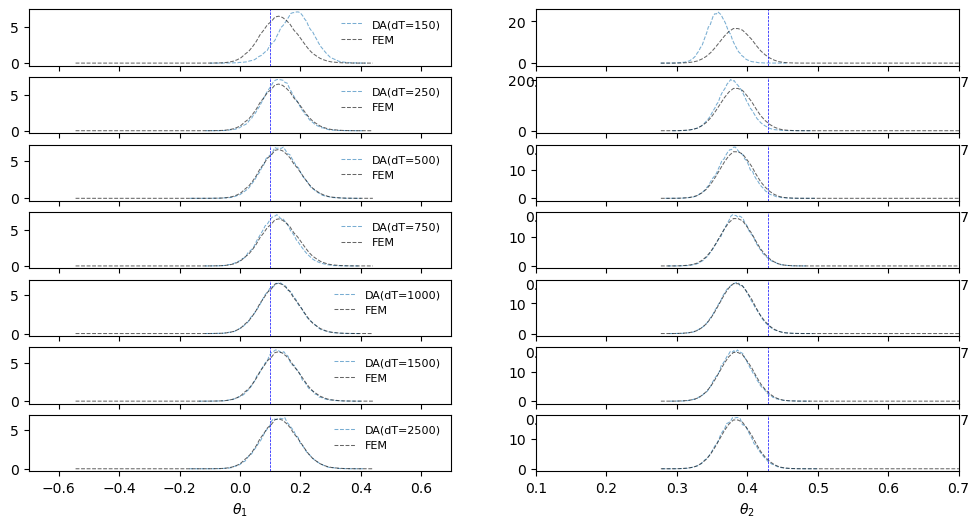

In [16]:
fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
bins =80
theta_th=np.array([0.098, 0.430])

for i,nobs in  enumerate(N):
    sample = np.load(f'./results/delayed_neural_MCMCM_s{nobs}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"DA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"DA(dT={nobs})")

    sample = np.load(f'./results/FEM_h{50}_var{1e-4}_.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].set_xlim((0.1,0.7)), axs[i,0].set_xlim((-0.7,0.7))


axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")

Text(0, 0.5, 'Acceptance Rate')

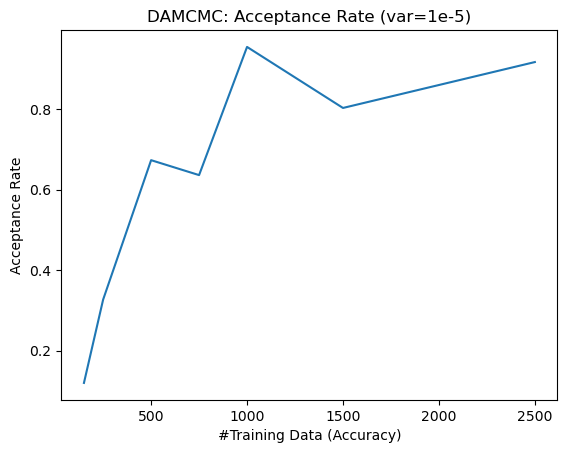

In [27]:
acceptace_list = [0.1197,0.3267, 0.6730,0.6359,0.9543,0.8027,0.9167]

plt.plot(N,acceptace_list)
plt.title("DAMCMC: Acceptance Rate (var=1e-5)")
plt.xlabel("#Training Data (Accuracy)")
plt.ylabel("Acceptance Rate")

Text(0, 0.5, 'Acceptance Rate')

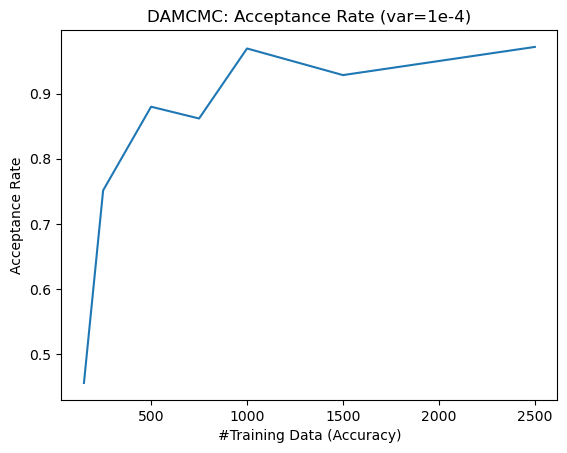

In [28]:
acceptace_list = [0.4555,0.7514,0.8800,0.8619,0.9695,0.9286,0.9719]

plt.plot(N,acceptace_list)
plt.title("DAMCMC: Acceptance Rate (var=1e-4)")
plt.xlabel("#Training Data (Accuracy)")
plt.ylabel("Acceptance Rate")

# Var 1e-5

In [11]:
dy = 6
st = np.sqrt(1e-5)

X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 5
dy = 6
eta = np.random.normal(0,10**(-k/2),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])
y = y_tia + eta

y = y.reshape(-1,1)

In [12]:
N = [150,250,500,750,1000,1500,2500]
for nobs in N:
    print(f"Starting NN: s_{nobs}")
    nn_surrogate_model = torch.load(f"./models/MDNN_s{nobs}.pth")
    nn_surrogate_model.eval()

    mcmc_nn = DAHM_NN(X,y,nn_surrogate_model,sig = st)

    samples_ = mcmc_nn.run_sampler(n_chains=1000000,burn_in=500000)

    np.save(f'./results/delayed_neural_MCMCM_s{nobs}_s{1e-5}.npy', samples_)

Starting NN: s_150
Burn-in 100000, Acceptance Rate: 0.0035, Step Size: 0.0815
Burn-in 200000, Acceptance Rate: 0.0050, Step Size: 0.0696
Burn-in 300000, Acceptance Rate: 0.0064, Step Size: 0.0635
Burn-in 400000, Acceptance Rate: 0.0073, Step Size: 0.0596
Starting Delayed Acceptance....
Iteration 100000, Acceptance Rate: 0.0041, Step Size: 0.0567


KeyboardInterrupt: 

# Pyro sampler for FEM

In [23]:

# # Define the model using a coarse FEM solver
# def model(surrogate_fem_solver,synthetic_data, points,noise_std,vert):
#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

#     # Use a coarse mesh FEM solver as the surrogate model
#     surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

#     surrogate_fem_solver.uh = None

#     surrogate_fem_solver.solve()

#     # Get model predictions at the given points
#     model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points))

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data))

#     return y


# # Define the model using a coarse FEM solver
# def model_MY(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):

#     lam = 0.001  # Set your lambda value for the Moreau-Yosida prior
#     moreau_prior = MoreauYosidaPrior(lam,device=device)

#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", moreau_prior.expand([2]))

#     # Use a coarse mesh FEM solver as the surrogate model
#     surrogate_fem_solver.theta = theta.detach().cpu().numpy()  # Update the parameter vector

#     surrogate_fem_solver.uh = None

#     surrogate_fem_solver.solve()

#     # Get model predictions at the given points
#     model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

#     return y


# theta_th=np.array([0.098, 0.430])
# vr = 1e-3
# obs = 10
# vertices = [2,25,100]

# st = np.sqrt(vr)

# obs_points, obs_sol = generate_noisy_obs(obs, theta_t=theta_th, mean=0, std=st,vert=200)

# # Define the MCMC kernel (using Random Walk Metropolis)
# kernel = mcmc.RandomWalkKernel(model, target_accept_prob=0.234)

# # Create an MCMC object with the kernel
# mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

# for hvert in vertices:
#     surrogate_fem_solver = FEMSolver(theta=np.zeros(theta_th.shape[0]), vert=hvert)

#     # Run the MCMC inference
#     mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st,hvert)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{obs}.npy', samples)


Sample: 100%|██████████| 1005000/1005000 [42:07, 397.67it/s, step size=9.96e-01, acc. prob=0.121]
